In [74]:
# ============== 1. Импорт необходимых библиотек ==============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Импорт CatBoostRegressor (убедитесь, что catboost установлен: pip install catboost)
from catboost import CatBoostRegressor

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# ============== 2. Функции для предобработки данных ==============
def extract_numeric(text):
    """Извлекает число из строки, например, '142 min' -> 142."""
    m = re.search(r'\d+', str(text))
    return float(m.group()) if m else np.nan

def clean_budget(x):
    """Извлекает число из строки бюджета (например, '$150,000,000')."""
    if pd.isnull(x):
        return np.nan
    cleaned = re.sub(r'[^\d]', '', str(x))
    return float(cleaned) if cleaned != "" else np.nan

def clean_votes(x):
    """Извлекает число из строки голосов (например, '1,234,567')."""
    if pd.isnull(x):
        return np.nan
    cleaned = re.sub(r'[^\d]', '', str(x))
    return float(cleaned) if cleaned != "" else np.nan

def mean_absolute_percentage_error(y_true, y_pred, eps=1e-10):
    """Вычисляет MAPE с защитой от деления на ноль."""
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

In [ ]:
# Определяем именованную функцию-идентичность вместо lambda
def identity_func(x):
    return x

In [ ]:

# ============== 3. Загрузка и первоначальная предобработка данных ==============
df = pd.read_excel("imdb_top_1000.xlsx")
print("Столбцы в датасете:", df.columns.tolist())
# Ожидаемые столбцы: ['Name', 'Released_Year', 'IMDB_Rating', 'Runtime', 'Genre',
# 'Overview', 'Rating', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Movie_Budget']

# Приводим столбцы с категориальными признаками к строковому типу
df["IMDB_Rating"] = df["IMDB_Rating"].astype(str)
df["Director"] = df["Director"].astype(str)

# Извлекаем числовые признаки
df["Runtime_num"] = df["Runtime"].apply(extract_numeric)
df["Movie_Budget_num"] = df["Movie_Budget"].apply(clean_budget)
df["No_of_Votes_num"] = df["No_of_Votes"].apply(clean_votes)
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")

# Объединяем текст: Overview + Genre
df["combined_text"] = df["Overview"].fillna('') + " " + df["Genre"].fillna('')

# Дополнительные признаки: длина описания и количество жанров
df["overview_length"] = df["Overview"].fillna('').apply(lambda x: len(x.split()))
df["num_genres"] = df["Genre"].fillna('').apply(lambda x: len(x.split(',')))

# Ограничиваем категорию Director: оставляем топ-20, остальные заменяем на 'Other'
top_directors = df["Director"].value_counts().nlargest(20).index
df["Director_clean"] = df["Director"].where(df["Director"].isin(top_directors), other="Other")

# Удаляем строки с пропусками в ключевых столбцах
key_cols = ["Rating", "Runtime_num", "Movie_Budget_num", "No_of_Votes_num",
            "Released_Year", "combined_text", "Director_clean", "IMDB_Rating"]
df_model = df.dropna(subset=key_cols).copy()
print("Размер выборки после dropna:", df_model.shape)

# Приводим столбец Rating к числовому типу
df_model["Rating"] = pd.to_numeric(df_model["Rating"], errors="coerce")
# Фильтруем строки, где Rating == 0, чтобы исключить нули из выборки
df_model = df_model[df_model["Rating"] != 0].copy()
print("Размер выборки после удаления нулевых значений Rating:", df_model.shape)

In [ ]:
# ============== 4. Формирование обучающей выборки ==============
features = [
    "combined_text",         # Текст: объединение Overview и Genre
    "Released_Year",         # Год выпуска
    "Runtime_num",           # Продолжительность
    "Movie_Budget_num",      # Бюджет
    "No_of_Votes_num",       # Количество голосов
    "Director_clean",        # Режиссёр (топ-20)
    "IMDB_Rating",           # IMDb_Rating (категория)
    "overview_length",       # Длина описания
    "num_genres"             # Количество жанров
]
target = "Rating"

X = df_model[features]
y = df_model[target]

# Разбиваем выборку на обучающую и тестовую (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

In [ ]:



# ============== 5. Построение пайплайна предобработки ==============
# Текстовый пайплайн: TfidfVectorizer -> TruncatedSVD (для разреженной матрицы)
text_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=2000, stop_words="english", ngram_range=(1,3))),
    ("svd", TruncatedSVD(n_components=50, random_state=42))
])

# Числовой пайплайн: SimpleImputer + StandardScaler
num_features = ["Released_Year", "Runtime_num", "Movie_Budget_num", "No_of_Votes_num", "overview_length", "num_genres"]
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

# Категориальные признаки: используем FunctionTransformer с именованной функцией identity_func
cat_features = ["Director_clean", "IMDB_Rating"]
cat_pipeline = Pipeline([
    ("passthrough", FunctionTransformer(identity_func, validate=False))
])

# Объединяем всё через ColumnTransformer:
# Текст: 50 признаков, Числовые: 6 признаков, Категориальные: 2 признака
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_pipeline, "combined_text"),
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)
    ],
    sparse_threshold=0
)


In [ ]:
# ============== 6. Преобразование в DataFrame после ColumnTransformer ==============
from sklearn.base import TransformerMixin, BaseEstimator

class ToDataFrame(TransformerMixin, BaseEstimator):
    def __init__(self, text_features_len, num_features, cat_features):
        self.text_features_len = text_features_len  # например, 50
        self.num_features = num_features
        self.cat_features = cat_features
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        n_text = self.text_features_len
        n_num = len(self.num_features)
        n_cat = len(self.cat_features)
        text_cols = [f"text_{i}" for i in range(n_text)]
        num_cols = self.num_features
        cat_cols = self.cat_features
        columns = text_cols + num_cols + cat_cols
        df_out = pd.DataFrame(X, columns=columns)
        # Приводим категориальные столбцы к строковому типу
        for col in cat_cols:
            df_out[col] = df_out[col].astype(str)
        return df_out

full_preprocessor = Pipeline([
    ("preproc", preprocessor),
    ("to_df", ToDataFrame(text_features_len=50, num_features=num_features, cat_features=cat_features))
])


In [ ]:

# ============== 7. Построение модели ==============
# Определяем имена столбцов категориальных признаков (как они будут в DataFrame)
cat_features_names = cat_features  # ["Director_clean", "IMDB_Rating"]

# Инициализируем CatBoostRegressor. Если DataFrame передан, можно указать имена категориальных столбцов.
catboost_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    random_seed=42,
    verbose=0
)

# Обертка для CatBoost для передачи категориальных столбцов по именам
from sklearn.base import BaseEstimator, RegressorMixin

class CatBoostWrapper(BaseEstimator, RegressorMixin):

    def __init__(self, model, cat_features, lower_bound=1.0, upper_bound=10.0):
        self.model = model
        self.cat_features = cat_features
        self.lower_bound = lower_bound  # Минимальное значение — 1.0
        self.upper_bound = upper_bound
        
    def fit(self, X, y):
        # Обучаем модель; y уже должен быть числовым
        self.model.fit(X, y, cat_features=self.cat_features)
        return self
        
    def predict(self, X):
        preds = self.model.predict(X)
        preds = np.array(preds, dtype=float)
        # Стандартное ограничение с помощью np.clip
        preds = np.clip(preds, self.lower_bound, self.upper_bound)
        # Дополнительная защита: если вдруг значение меньше lower_bound — устанавливаем lower_bound
        preds[preds < self.lower_bound] = self.lower_bound
        return preds
        
    def set_params(self, **params):
        self.model.set_params(**params)
        return self

wrapped_catboost = CatBoostWrapper(catboost_model, cat_features=cat_features_names)

In [ ]:
# ============== 8. Собираем общий пайплайн ==============
mega_pipeline = Pipeline([
    ("full_preprocessor", full_preprocessor),
    ("regressor", wrapped_catboost)
])

In [ ]:

# ============== 9. Обучение модели ==============
mega_pipeline.fit(X_train, y_train)
y_pred = mega_pipeline.predict(X_test)

# Дополнительно: защита предсказаний (на случай, если что-то просочится)
y_pred = np.maximum(np.array(y_pred, dtype=float), 1.0)

In [ ]:
# ============== 10. Вычисление метрик ==============
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R2 на тесте = {r2:.3f}")
print(f"MSE на тесте = {mse:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.3f}")

In [ ]:
# ============== 11. Визуализация результатов ==============
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test.values, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel("Настоящий рейтинг")
plt.ylabel("Предсказанный рейтинг")
plt.title("Actual vs Predicted Ratings")
plt.grid(True)
plt.show()

In [ ]:
# ============== 12. Сохранение модели ==============
model_filename = "best_movie_rating_mega_model.pkl"
joblib.dump(mega_pipeline, model_filename)
print(f"Модель сохранена в файл {model_filename}")

In [ ]:
# ============== 13. Функция для предсказания на новых данных ==============
def predict_rating(overview, genre, released_year, runtime, budget, votes, director, imdb_rating):
    """
    Принимает входные данные:
      - overview: описание фильма,
      - genre: жанры,
      - released_year: год выпуска (число),
      - runtime: продолжительность (например, '142 min' или число),
      - budget: бюджет (например, '$150,000,000' или число),
      - votes: количество голосов (например, '1,234,567' или число),
      - director: режиссёр,
      - imdb_rating: категорийное значение IMDb_Rating (например, 'A', 'UA', 'U').
    Если режиссёр не входит в топ-20, заменяется на 'Other'.
    Возвращает предсказанный рейтинг.
    """
    combined_text = str(overview) + " " + str(genre)
    runtime_val = extract_numeric(runtime) if isinstance(runtime, str) else float(runtime)
    budget_val = clean_budget(budget) if isinstance(budget, str) else float(budget)
    votes_val = clean_votes(votes) if isinstance(votes, str) else float(votes)
    director_val = director if director in top_directors else "Other"
    
    sample = pd.DataFrame([{
        "combined_text": combined_text,
        "Released_Year": released_year,
        "Runtime_num": runtime_val,
        "Movie_Budget_num": budget_val,
        "No_of_Votes_num": votes_val,
        "Director_clean": director_val,
        "IMDB_Rating": str(imdb_rating),
        "overview_length": len(str(overview).split()),
        "num_genres": len(str(genre).split(','))
    }])
    
    # Получаем предсказание и дополнительно гарантируем, что значение не ниже 1.0
    prediction = mega_pipeline.predict(sample)[0]
    prediction = max(float(prediction), 1.0)
    return prediction

# Пример вызова функции предсказания:
pred_example = predict_rating(
    overview="A futuristic odyssey of self-discovery and adventure.",
    genre="Sci-Fi, Adventure",
    released_year=2020,
    runtime="130 min",
    budget="$80,000,000",
    votes="345,678",
    director="Christopher Nolan",
    imdb_rating="A"
)
print(f"Пример предсказания: {pred_example:.2f}")


Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

In [ ]:
# Результаты
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший R2 на кросс-валидации:", grid_search.best_score_)

import math
# Тестовая метрика
y_pred = grid_search.predict(X_test)
print("R2 на тесте = ", r2_score(y_test, y_pred))
print("MSE на тесте =", mean_squared_error(y_test, y_pred))
print("RMSE = ", math.sqrt(mean_squared_error(y_test, y_pred)))

# Убираем нули из y_test перед вычислением MAPE
y_test_safe = np.where(y_test == 0, np.nan, y_test)  # заменяем нули на NaN
y_pred_safe = y_pred[~np.isnan(y_test_safe)]  # удаляем строки с NaN в y_test
y_test_safe = y_test_safe[~np.isnan(y_test_safe)]  # удаляем соответствующие строки в y_test

# Теперь можно безопасно вычислить MAPE
mape = np.mean(np.abs(y_test_safe - y_pred_safe) / y_test_safe) * 100
print("MAPE = ", mape)

Лучшие параметры: {'regressor__final_estimator__alpha': 10.0, 'regressor__gbr__max_depth': 3}
Лучший R2 на кросс-валидации: 0.15686232225356203
R2 на тесте =  0.3143985723840782
MSE на тесте = 6.583042381979991
RMSE =  2.5657440211330496
MAPE =  19.735681603355893


Столбцы в датасете: ['Name', 'Released_Year', 'IMDB_Rating', 'Runtime', 'Genre', 'Overview', 'Rating', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Movie_Budget']
Размер выборки после dropna: (993, 19)
X_train: (794, 7) X_test: (199, 7)
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Лучшие параметры: {'regressor__final_estimator__alpha': 10.0, 'regressor__gbr__max_depth': 4}
Лучший R2 на кросс-валидации: 0.12343502176238703
R2 на тесте = 0.269
MSE на тесте = 7.270
RMSE = 2.696
MAPE = 780184502552.765


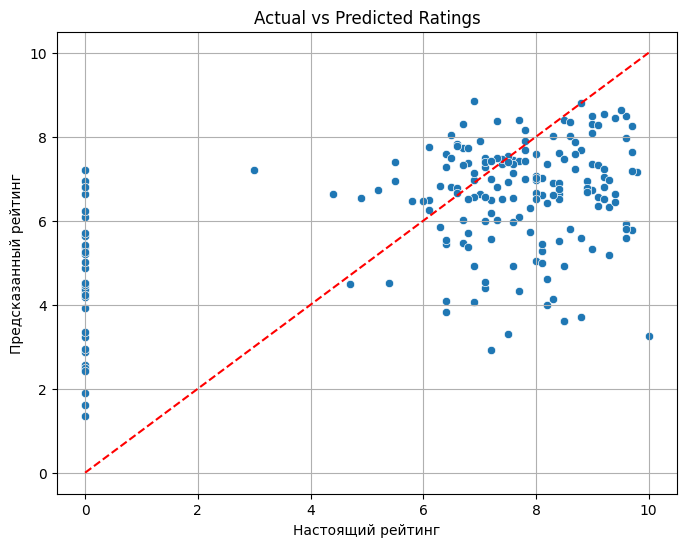

Модель сохранена в файл best_movie_rating_model.pkl
Пример предсказания: 7.47
